In [1]:
import torch as tc
import torch.nn as nn
import numpy as np
from bptt.models import Model
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sys
import os
#add the above folder to load packags
sys.path.append(os.path.join("..", ""))


In [2]:
X_gaussian = tc.tensor(np.load("datasets/lorenz/lorenz_multimodal_gaussian_dt0.05_test.npy"), dtype=tc.float)
X_ordinal = tc.tensor(np.load("datasets/lorenz/lorenz_multimodal_ordinal_dt0.05_test.npy"), dtype=tc.float)
X_poisson = tc.tensor(np.load("datasets/lorenz/lorenz_multimodal_poisson_dt0.05_test.npy"), dtype=tc.float)
X=tc.cat((X_gaussian,X_ordinal, X_poisson), axis=-1)[:]

In [3]:
m = Model()

m.init_from_model_path("results/lorenz_example/001", 1000)

In [4]:
#generate a trajectory for all 3 modalities

initial_state=X[:]
T_gen=5000
tmp, latent = m.generate_free_trajectory(initial_state, T_gen)


C:\Users\manuel.brenner\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:207: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
C:\Users\manuel.brenner\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


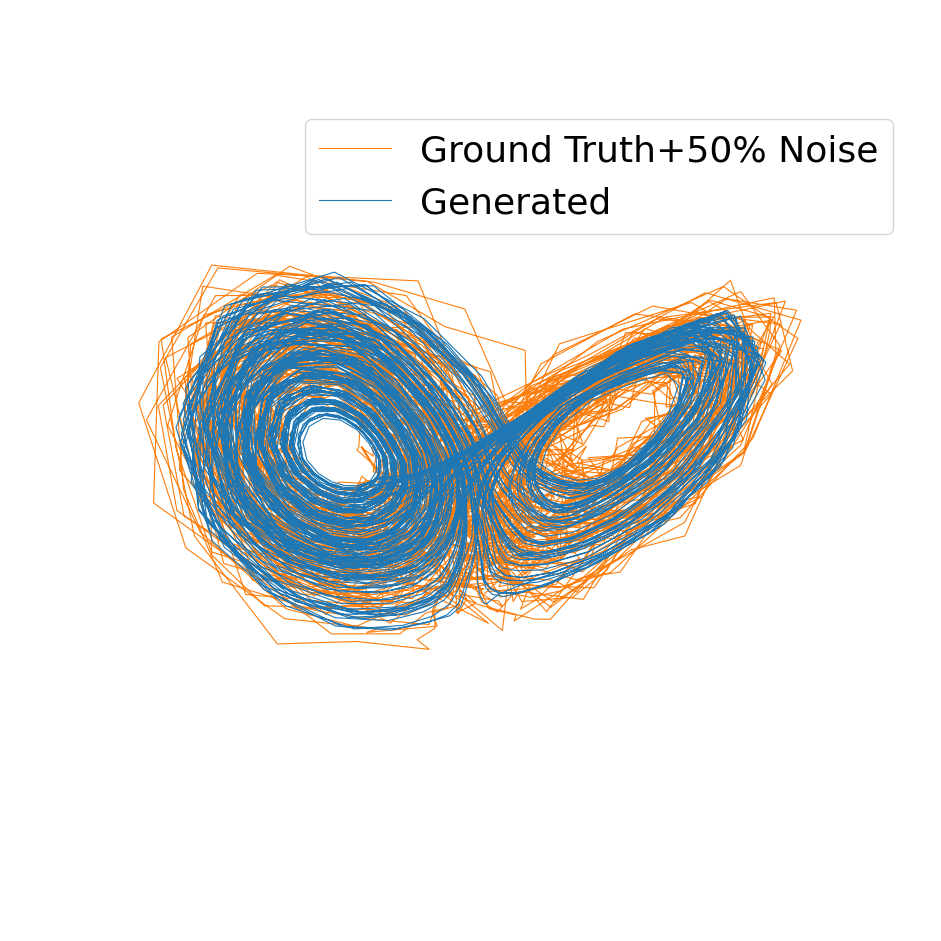

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams.update({'font.size': 26})
plt.rcParams.update({'lines.linewidth': 0.8})

#remove transients
plot_data=tmp.detach().numpy()[500:]
T_plot=3000

plot_gaussian=X_gaussian[1000:]+tc.randn_like(X_gaussian[1000:])*0.15

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.plot(plot_gaussian[:T_plot, 0], plot_gaussian[:T_plot, 1], plot_gaussian[:T_plot, 2], label='Ground Truth+50% Noise', color="C1")
ax.plot(plot_data[:T_plot, 0], plot_data[:T_plot, 1], plot_data[:T_plot, 2], label='Generated', color="C0")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.axis("off")


# Adjust legend position closer to the plot
ax.legend(loc='upper left', bbox_to_anchor=(0.3, 0.9))

plt.tight_layout()

plt.show()

In [6]:
"""
Compute the Lyapunov spectrum of the PLRNN model `ℳ` given initial condition `z₁`.

The system is first evolved for `Tₜᵣ` steps to reach the attractor,

and then the spectrum is computed across `T` steps. 

"""

def lyapunov_spectrum(T, T_trans=100, ons=5):

    # evolve for transient time Tₜᵣ

    initial_state=X[:]
    tmp, latent = m.generate_free_trajectory(initial_state, T)

    # initialize
    z=latent[-1].requires_grad_(True)
    y = tc.zeros(z.shape[0])
    # initialize as Identity matrix
    Q = tc.eye((z.shape[-1]))
    
    trajectory=[]
    jacob=[]
    for t in range(T):
        
        z=m.latent_model.generate_step(z)
        inputs = (z)
        jacobians=tc.autograd.functional.jacobian(m.latent_model.generate_step,inputs)
        
        trajectory.append(z[0])
        # compute jacobian
        Q = tc.matmul(jacobians,Q)
        
        if (t%ons == 0):

            # reorthogonalize

            Q, R = tc.linalg.qr(Q)

            # accumulate lyapunov exponents

            y += tc.log(tc.abs(tc.diag(R)))

    return y / T, tc.stack(trajectory)


In [ ]:
# D_stsp
def calc_histogram(x, n_bins, min_, max_):
    dim_x = x.shape[1]  # number of dimensions

    coordinates = (n_bins * (x - min_) / (max_ - min_)).long()

    # discard outliers
    coord_bigger_zero = coordinates > 0
    coord_smaller_nbins = coordinates < n_bins
    inlier = coord_bigger_zero.all(1) * coord_smaller_nbins.all(1)
    coordinates = coordinates[inlier]

    size_ = tuple(n_bins for _ in range(dim_x))
    indices = tc.ones(coordinates.shape[0], device=coordinates.device)
    if 'cuda' == coordinates.device.type:
        tens = tc.cuda.sparse.FloatTensor
    else:
        tens = tc.sparse.FloatTensor
    return tens(coordinates.t(), indices, size=size_).to_dense()

def normalize_to_pdf_with_laplace_smoothing(histogram, n_bins, smoothing_alpha=10e-6):
    if histogram.sum() == 0:  # if no entries in the range
        pdf = None
    else:
        dim_x = len(histogram.shape)
        pdf = (histogram + smoothing_alpha) / (histogram.sum() + smoothing_alpha * n_bins ** dim_x)
    return pdf

def kullback_leibler_divergence(p1, p2):
    """
    Calculate the Kullback-Leibler divergence
    """
    if p1 is None or p2 is None:
        kl = tc.tensor([float('nan')])
    else:
        kl = (p1 * tc.log(p1 / p2)).sum()
    return kl

def state_space_divergence_binning(x_gen, x_true, n_bins=30):
    x_true_ = tc.tensor(x_true)
    x_gen_ = tc.tensor(x_gen)
    min_, max_ = x_true_.min(0).values, x_true_.max(0).values
    hist_gen = calc_histogram(x_gen_, n_bins=n_bins, min_=min_, max_=max_)
    hist_true = calc_histogram(x_true_, n_bins=n_bins, min_=min_, max_=max_)

    p_gen = normalize_to_pdf_with_laplace_smoothing(histogram=hist_gen, n_bins=n_bins)
    p_true = normalize_to_pdf_with_laplace_smoothing(histogram=hist_true, n_bins=n_bins)
    return kullback_leibler_divergence(p_true, p_gen).item()

def clean_from_outliers(prior, posterior):
    nonzeros = (prior != 0)
    if any(prior == 0):
        prior = prior[nonzeros]
        posterior = posterior[nonzeros]
    outlier_ratio = (1 - nonzeros.float()).mean()
    return prior, posterior, outlier_ratio

In [ ]:
lyap, traj=lyapunov_spectrum(4000, T_trans=200, ons=5)


In [ ]:
#multiply by factor 20 to account for integration constant dt=0.05
print("Maximum Lyapunov Exponent:", tc.max(lyap)*20)

In [7]:
from evaluation import klx

In [14]:
limiting_set=[]

#generate one long or several short trajectories
for i in range(1):
    gen, latent = m.generate_free_trajectory(initial_state, 101000)
    limiting_set.append(gen[1000:,:3])
    
X_gen=tc.stack(limiting_set)
X_gen=X_gen.reshape(1,-1,3).squeeze(0)


In [24]:
#calculate D_stsp with the binning method

D_stsp = klx.klx_metric(X_gen[:,:3], X_gaussian, 10) 
print("KL Divergence:", np.round(D_stsp.numpy(),2))

KL Divergence: 0.33
